DistilBERT fine-tuning으로 감정 분석 모델 학습하기
이번 실습에서는 pre-trained된 DistilBERT를 불러와 이전 주차 실습에서 사용하던 감정 분석 문제에 적용합니다. 먼저 필요한 library들을 불러옵니다.

### 과제 요구 사항들을 구현하고, epoch마다의 train loss와 최종 모델의 test accuracy가 print된 notebook을 public github repository에 업로드하여 공유해주시면 됩니다. 반드시 출력 결과가 남아있어야 합니다.
- [o] AG_News dataset 준비
    - Huggingface dataset의 `fancyzhx/ag_news`를 load
    - `collate_fn` 함수에 다음 수정사항들을 반영
    - Truncation과 관련된 부분들을 삭제
- [o] Classifier output, loss function, accuracy function 변경
    - 뉴스 기사 분류 문제는 binary classification이 아닌 일반적인 classification 문제입니다. MNIST 과제에서 했던 것 처럼 `nn.CrossEntropyLoss` 를 추가하고 `TextClassifier`의 출력 차원을 잘 조정하여 task를 풀 수 있도록 수정
    - 그리고 정확도를 재는 `accuracy` 함수도 classification에 맞춰 수정
- [o]  학습 결과 report
    - DistilBERT 실습과 같이 매 epoch 마다의 train loss를 출력하고 최종 모델의 test accuracy를 report 첨부

In [1]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behav

그 후, 우리가 사용하는 DistilBERT pre-training 때 사용한 tokenizer를 불러옵니다.

In [2]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

# DistilBERT 모델용 tokenizer 로드 (pretrained)
# 이 tokenizer는 문장을 토큰화해서 모델이 이해할 수 있는 input_ids로 변환해줌
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://hu

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBERT의 tokenizer를 불러왔으면 이제 collate_fn과 data loader를 정의합니다. 이 과정은 이전 실습과 동일하게 다음과 같이 구현할 수 있습니다.

In [3]:
# IMDB 감정 분석 데이터셋의 5%만 로드 (학습 데이터와 테스트 데이터 각각)
# 4개 카테고리(world/sports/Business/Sci,Tech)
train_ds = load_dataset("fancyzhx/ag_news", split="train[:5%]")
test_ds = load_dataset("fancyzhx/ag_news", split="test[:5%]")

#첫번째 샘플 데이터 확인
print("train sample: ", train_ds[0])
print("test sample:", test_ds[0])

#샘플 개수 확인
print("train sample count: ", len(train_ds))
print("test sample count: ", len(test_ds))

# 데이터를 배치로 묶기 위한 함수 정의
def collate_fn(batch):
    texts, labels = [], []  # 입력 문장들과 라벨들을 저장할 리스트

    # 배치 내 각 샘플에 대해 text와 label 추출
    for row in batch:
        labels.append(row['label'])
        texts.append(row['text'])

    # tokenizer로 텍스트를 토큰화하고, 최대 길이로 패딩 및 자르기
    # tokenizer는 사전에 정의되어 있어야 함 (예: tokenizer = AutoTokenizer.from_pretrained(...))
    texts = torch.LongTensor(tokenizer(texts, padding=True).input_ids)
    # 라벨 리스트를 LongTensor로 변환
    labels = torch.LongTensor(labels)

    # 모델 학습에 필요한 입력 (토큰화된 문장들)과 정답 라벨 반환
    return texts, labels

# 학습용 DataLoader 정의 (shuffle=True로 배치 순서 랜덤화)
train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn
)

# 테스트용 DataLoader 정의 (shuffle=False로 배치 순서 고정)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn
)

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

train sample:  {'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}
test sample: {'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.", 'label': 2}
train sample count:  6000
test sample count:  380


이제 pre-trained DistilBERT를 불러옵니다. 이번에는 PyTorch hub에서 제공하는 DistilBERT를 불러봅시다.

In [4]:
#DistilBERT 모델을 PyTorch Hub에서 로드 후 model 출력
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
model

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

출력 결과를 통해 우리는 DistilBERT의 architecture는 일반적인 Transformer와 동일한 것을 알 수 있습니다. Embedding layer로 시작해서 여러 layer의 Attention, FFN를 거칩니다.

이제 DistilBERT를 거치고 난 [CLS] token의 representation을 가지고 text 분류를 하는 모델을 구현합시다.

In [5]:
from torch import nn

# 텍스트 분류 모델 정의 (DistilBERT + Linear layer)
class TextClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # 사전학습된 DistilBERT 모델을 encoder로 불러옴 (pretrained transformer)
        self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')


        # [CLS] 토큰 분류기 정의 
        self.classifier = nn.Linear(768, 4)

    def forward(self, x):
        # encoder에 input_ids 전달
        x = self.encoder(x)['last_hidden_state']

        # [CLS] 토큰 위치 벡터를 classification head에 전달
        x = self.classifier(x[:, 0])

        return x  # logit 출력

model = TextClassifier()

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


위와 같이 TextClassifier의 encoder를 불러온 DistilBERT, 그리고 classifier를 linear layer로 설정합니다. 그리고 forward 함수에서 순차적으로 사용하여 예측 결과를 반환합니다.

다음은 마지막 classifier layer를 제외한 나머지 부분을 freeze하는 코드를 구현합니다.

In [6]:
for param in model.encoder.parameters():
  param.requires_grad = False

위의 코드는 encoder에 해당하는 parameter들의 requires_grad를 False로 설정하는 모습입니다. requires_grad를 False로 두는 경우, gradient 계산 및 업데이트가 이루어지지 않아 결과적으로 학습이 되지 않습니다. 즉, 마지막 classifier에 해당하는 linear layer만 학습이 이루어집니다. 이런 식으로 특정 부분들을 freeze하게 되면 효율적으로 학습을 할 수 있습니다.

마지막으로 이전과 같은 코드를 사용하여 학습 결과를 확인해봅시다.

In [7]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

def accuracy(model, dataloader):
    cnt = 0      # 전체 샘플 수
    acc = 0      # 정답 개수 누적

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)  # 로짓(logit) 출력
        preds = torch.argmax(preds, dim=-1)

        cnt += labels.shape[0]  # 총 샘플 수 누적
        acc += (labels == preds).sum().item()  # 예측이 맞은 수 누적

    return acc / cnt  # 정확도 반환

#학습 과정 시각화 함수
def plot_acc(train_acc, test_acc):
  x = np.arange(len(train_acc))

  plt.plot(x, train_acc, label='train') #학습 데이터 정확도 그래프
  plt.plot(x, test_acc, label='test') #테스트 데이터 정확도 그래프
  plt.legend()
  plt.show()

def plot_loss(losses):
    plt.plot(np.arange(len(losses)), losses, label='train_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Time')
    plt.legend()
    plt.show()

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


[Epoch 01/30] Loss: 98.6848 | Train Acc: 0.8063 | Test Acc: 0.8026
[Epoch 02/30] Loss: 68.9752 | Train Acc: 0.8198 | Test Acc: 0.8158
[Epoch 03/30] Loss: 58.8979 | Train Acc: 0.8203 | Test Acc: 0.8395
[Epoch 04/30] Loss: 54.1513 | Train Acc: 0.8382 | Test Acc: 0.8421
[Epoch 05/30] Loss: 51.1447 | Train Acc: 0.8317 | Test Acc: 0.8421
[Epoch 06/30] Loss: 49.8861 | Train Acc: 0.8393 | Test Acc: 0.8447
[Epoch 07/30] Loss: 47.2094 | Train Acc: 0.8438 | Test Acc: 0.8395
[Epoch 08/30] Loss: 47.2848 | Train Acc: 0.8395 | Test Acc: 0.8474
[Epoch 09/30] Loss: 46.0521 | Train Acc: 0.8427 | Test Acc: 0.8395
[Epoch 10/30] Loss: 44.6926 | Train Acc: 0.8470 | Test Acc: 0.8605
[Epoch 11/30] Loss: 44.6393 | Train Acc: 0.8502 | Test Acc: 0.8579
[Epoch 12/30] Loss: 43.0391 | Train Acc: 0.8510 | Test Acc: 0.8447
[Epoch 13/30] Loss: 42.2279 | Train Acc: 0.8508 | Test Acc: 0.8421
[Epoch 14/30] Loss: 43.2142 | Train Acc: 0.8545 | Test Acc: 0.8632
[Epoch 15/30] Loss: 42.3559 | Train Acc: 0.8480 | Test Acc: 0.

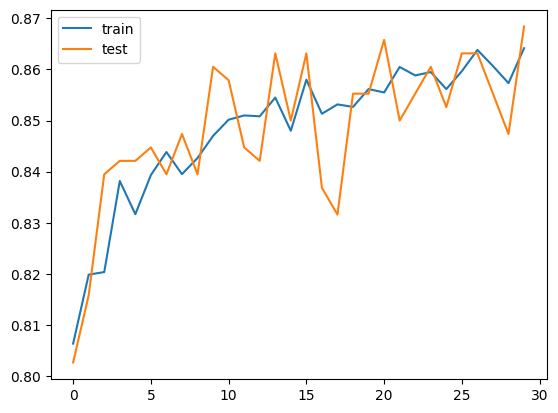

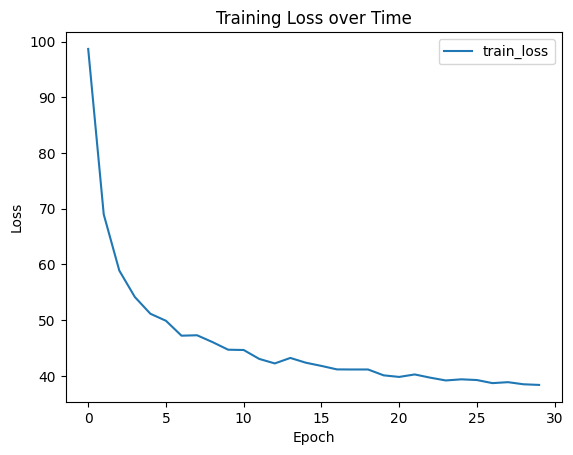

In [8]:
# 학습 설정
lr = 0.001
model = model.to('cuda')  # 모델을 GPU로 이동
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)
train_acc= []
test_acc = []
train_losses = []

n_epochs = 30

# 학습 루프
for epoch in range(n_epochs):
    total_loss = 0.
    model.train()  # 학습 모드 설정

    for data in train_loader:
        model.zero_grad()  # 이전 gradient 초기화

        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)
        loss = loss_fn(preds, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 파라미터 업데이트

        total_loss += loss.item()  # loss 누적

    train_acc.append(accuracy(model, train_loader))
    test_acc.append(accuracy(model, test_loader))
    print(f"[Epoch {epoch+1:02d}/{n_epochs}] Loss: {total_loss:.4f} | Train Acc: {train_acc[-1]:.4f} | Test Acc: {test_acc[-1]:.4f}")

    train_losses.append(total_loss)

plot_acc(train_acc, test_acc) #학습 결과 시각화
plot_loss(train_losses) #손실값 시각화

In [9]:
# 평가 시 gradient 계산 비활성화
with torch.no_grad():
    model.eval()  # 평가 모드로 전환 (계산 비활성화)
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)

    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")


=========> Train acc: 0.868 | Test acc: 0.861
